# Application: using Piven on yearpredictionMSD dataset

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from piven.models import PivenMlpModel
import tensorflow as tf
from sklearn.compose import TransformedTargetRegressor

dpath = Path("data/YearPredictionMSD.txt")

In [ ]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [ ]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [ ]:
records = []
with dpath.open("r") as infile:
    for line in infile.readlines():
        line_split = line.replace("\n", "").split(",")
        year = int(line_split[0])
        inputs = [*map(lambda x: float(x), line_split[1:])]
        records.append([year] + inputs)

In [3]:
df = pd.DataFrame(records)

In [4]:
df.columns = ["year"] + [f"feature_{i}" for i in range(1, df.shape[-1])]

In [5]:
df.head()

,year,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [6]:
df.shape

(515345, 91)

In [7]:
# As per instructions https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD
train_samples = 463715
train = df.iloc[:train_samples,:]
test = df.iloc[train_samples:, :]

train_y = train.year.values
test_y = test.year.values
train_x = train.iloc[:, 1:].values
test_x = test.iloc[:, 1:].values

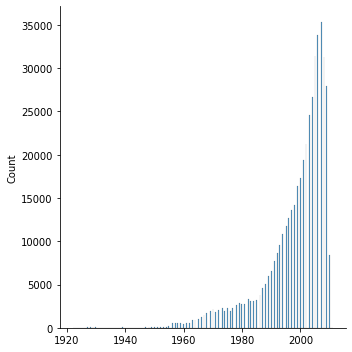

In [8]:
sns.displot(train_y)
plt.show()

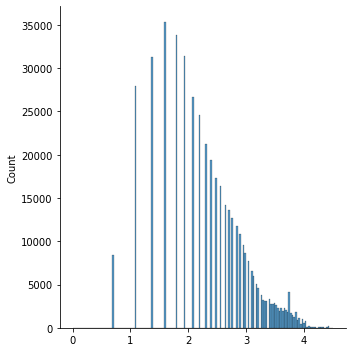

In [9]:
# Transform outcome variable (left-skewed)

max_out_train = np.max(train_y)

def reflect_and_log(x, max_out_train):
    return np.log(1 + max_out_train - train_y)

train_y_transformed = reflect_and_log(train_y, max_out_train)
test_y_transformed = reflect_and_log(test_y, max_out_train)

sns.displot(train_y_transformed)
plt.show()

In [64]:
from sklearn.preprocessing import StandardScaler
model_ttr = PivenMlpExperiment(
    input_dim = train_x.shape[-1],
    dense_units=(256, 256, 256),
    dropout_rate=(0.0, 0.0, 0.0),
    lambda_=20.0,
    bias_init_low=-3.0,
    bias_init_high=3.0,
    lr=0.000428,
)
model_ttr.build_model(preprocess=StandardScaler())

PivenTransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                           StandardScaler()),
                                                          ('model',
                                                           <piven.scikit_learn.wrappers.PivenKerasRegressor object at 0x7f96cc363790>)]),
                                transformer=StandardScaler())

In [65]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001
)

# Fit
h = model_ttr.fit(train_x, train_y_transformed, model__epochs=25, 
                  model__validation_split=0.2, model__batch_size=64,
                  model__callbacks=[early_stop, reduce_lr])

Epoch 1/25
5797/5797 [==============================] - 9s 2ms/step - loss: 24.1135 - picp: 0.8230 - mpiw: 7.8636 - val_loss: 6.8993 - val_picp: 0.9479 - val_mpiw: 5.3974
Epoch 2/25
3518/5797 [=================>............] - ETA: 3s - loss: 6.2954 - picp: 0.9161 - mpiw: 4.6468

KeyboardInterrupt: 

In [55]:
ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, return_prediction_intervals=True)

In [56]:
# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp
ypred = back_transform(ypred, max_out_train)
# Need to reverse the bounds
y_pi_low_t = back_transform(y_pi_high, max_out_train)
y_pi_high_t = back_transform(y_pi_low, max_out_train)

In [14]:
model_ttr.score(test_y, ypred, y_pi_low_t, y_pi_high_t)

{'loss': 120.73423137095416,
 'mae': 6.214852691892735,
 'rmse': 9.516718595827255,
 'coverage': 0.9361805152043385,
 'pi_width': 29.11503791809082}

In [57]:
model_ttr.score(test_y, ypred, y_pi_low_t, y_pi_high_t)

{'loss': 120.34295007850514,
 'mae': 6.171359573887366,
 'rmse': 9.477646612234524,
 'coverage': 0.9239589386015882,
 'pi_width': 27.402372360229492}

In [58]:
col_out = (y_pi_low_t <= test_y) & (test_y <= y_pi_high_t)
colmap = np.array(["green" if cov else "red" for cov in col_out])

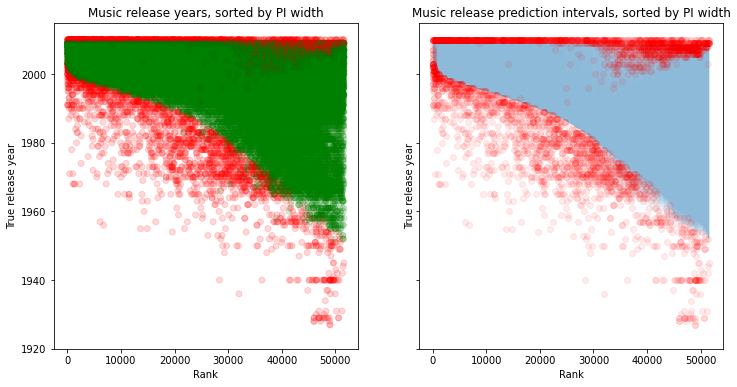

In [59]:
pi_width_sorted_idx = np.argsort(y_pi_high_t - y_pi_low_t)
test_y_sorted = test_y[pi_width_sorted_idx]
colmap_sorted = colmap[pi_width_sorted_idx]

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)
ax[0].scatter(range(test_y.shape[0]), test_y_sorted, c=colmap_sorted,alpha=0.15)
ax[0].set_ylim(1920, 2015)
ax[0].set_title("Music release years, sorted by PI width")
ax[0].set_xlabel("Rank")
ax[0].set_ylabel("True release year")

pred_wrong = test_y_sorted[colmap_sorted == "red"]
year_wrong = np.array([*range(test_y.shape[0])])[colmap_sorted == "red"]
ax[1].fill_between(
    range(test_y.shape[0]),
    y_pi_low_t[pi_width_sorted_idx],
    y_pi_high_t[pi_width_sorted_idx],
    alpha=0.5
)
ax[1].scatter(year_wrong, pred_wrong, c="r", alpha=0.08)
ax[1].set_ylim(1920, 2015)
ax[1].set_title("Music release prediction intervals, sorted by PI width")
ax[1].set_xlabel("Rank")
ax[1].set_ylabel("True release year")

plt.show()

In [60]:
outliers = df_res[df_res.true < 1960]
coverage(outliers.true, outliers.pi_low, outliers.pi_high)

outliers.head(10)

NameError: name 'df_res' is not defined

In [128]:
pi_width(outliers.pi_low, outliers.pi_high)

55.137226

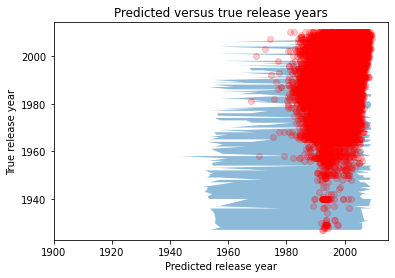

In [61]:
idx_sort = np.argsort(test_y)
plt.fill_betweenx(
    test_y[idx_sort],
    y_pi_low_t[idx_sort],
    y_pi_high_t[idx_sort],
    alpha=0.5
)
plt.scatter(ypred[idx_sort], test_y[idx_sort], c="r", alpha=0.2)
plt.xlim(1900, 2015)
plt.title("Predicted versus true release years")
plt.xlabel("Predicted release year")
plt.ylabel("True release year")
plt.show()

The PI are getting smaller as the true release year gets closer to 2012. This makes sense as the bulk of the data is there.

## With a regular MLP

In [130]:
def mlp_model(input_dim):    
    i = tf.keras.layers.Input(shape=(input_dim,))
    x = tf.keras.layers.Dense(
        64,
        activation="relu",
    )(i)
    x = tf.keras.layers.Dense(
        32,
        activation="relu",
    )(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    o = tf.keras.layers.Dense(
        1,
        activation="relu",
    )(x)
    model = tf.keras.models.Model(inputs=i, outputs=[o], name="MLP")
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss="mse")
    return model
mlp = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=mlp_model,
    input_dim=train_x.shape[-1]
)
pipeline = Pipeline([
    ("preprocess", StandardScaler()),
    ("model", mlp)
])
mlp_ttr = TransformedTargetRegressor(
    regressor=pipeline,
    transformer=StandardScaler()
)

In [131]:
mlp_ttr.fit(train_x, train_y_transformed, model__epochs=10, 
            model__validation_split=0.2, model__batch_size=64)

Epoch 1/10
5797/5797 [==============================] - 4s 730us/step - loss: 0.9594 - val_loss: 0.8530
Epoch 2/10
5797/5797 [==============================] - 4s 708us/step - loss: 0.8400 - val_loss: 0.8288
Epoch 3/10
5797/5797 [==============================] - 4s 716us/step - loss: 0.8191 - val_loss: 0.8169
Epoch 4/10
5797/5797 [==============================] - 4s 719us/step - loss: 0.8080 - val_loss: 0.8102
Epoch 5/10
5797/5797 [==============================] - 4s 727us/step - loss: 0.7994 - val_loss: 0.8073
Epoch 6/10
5797/5797 [==============================] - 4s 716us/step - loss: 0.7929 - val_loss: 0.8055
Epoch 7/10
5797/5797 [==============================] - 4s 710us/step - loss: 0.7922 - val_loss: 0.8026
Epoch 8/10
5797/5797 [==============================] - 4s 725us/step - loss: 0.7894 - val_loss: 0.8005
Epoch 9/10
5797/5797 [==============================] - 4s 720us/step - loss: 0.7869 - val_loss: 0.8006
Epoch 10/10
5797/5797 [==============================] - 4s 725u

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocess',
                                                      StandardScaler()),
                                                     ('model',
                                                      <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f7dfbd29bd0>)]),
                           transformer=StandardScaler())

In [132]:
ypred_mlp = mlp_ttr.predict(test_x)
ypred_mlp = back_transform(ypred_mlp, max_out_train)

In [133]:
print(mae(test_y, ypred_mlp))
print(np.sqrt(mse(test_y, ypred_mlp)))

6.479747074000853
9.371843016100332


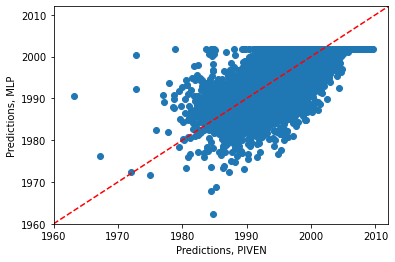

In [134]:
plt.scatter(ypred, ypred_mlp)
plt.xlim(1960, 2012)
plt.ylim(1960, 2012)
plt.xlabel("Predictions, PIVEN")
plt.ylabel("Predictions, MLP")
plt.plot(range(1960, 2015), range(1960, 2015), '--', c="r")
plt.show()

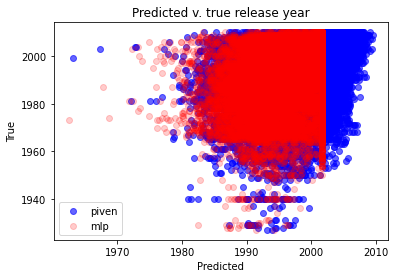

In [135]:
plt.scatter(ypred, test_y, c="b", alpha=0.6, label="piven")
plt.scatter(ypred_mlp, test_y, c="r", alpha=0.2, label="mlp")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.legend()
plt.title("Predicted v. true release year")
plt.show()

## Hyperparameter optimization

In [110]:
import optuna


def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001
)


def objective(trial: optuna.trial.Trial):
    lambda_ = trial.suggest_float("lambda_", 22.0, 28.0)
    lr = trial.suggest_loguniform("lr", 1e-5, 0.001)
    dropout_rate_l1 = trial.suggest_uniform("dropout_rate_l1", 0.0, 0.5)
    dropout_rate_l2 = trial.suggest_uniform("dropout_rate_l2", 0.0, 0.5)
    layer_size = trial.suggest_categorical("layer_size", 
                                           ["32+16", "64+32", 
                                            "128+64", "128+128"],
                                          )
    layer_size = tuple([int(ls) for ls in layer_size.split("+")])
    seed = trial.suggest_int("seed", 162, 9999999)
    np.random.seed(seed)
    # Split train from test data
    x_ind = [*range(train_x.shape[0])]
    np.random.shuffle(x_ind)
    train_x_trial, val_x_trial = train_x[:420000, :].copy(), train_x[420000:, :].copy()
    train_y_trial, val_y_trial = train_y[:420000].copy(), train_y[420000:].copy()
    max_train_out = np.max(train_y_trial)
    # Transform
    train_y_trial_transformed = reflect_and_log(train_y_trial, max_train_out)
    val_y_trial_transformed = reflect_and_log(val_y_trial, max_train_out)
    # Instantiate model
    model = PivenKerasRegressor(build_fn=piven_model, 
                              input_dim=train_x_trial.shape[-1], 
                              dense_units=layer_size, 
                              dropout_rate=(dropout_rate_l1, dropout_rate_l2),
                              lambda_=lambda_,
                              lr=lr)
    # Put model in pipeline
    pipeline = Pipeline([
        ("preprocess", StandardScaler()),
        ("model", model)
    ])
    model_ttr = PivenTransformedTargetRegressor(regressor=pipeline,
                                                transformer=StandardScaler())
    # Fit
    model_ttr.fit(train_x_trial, train_y_trial_transformed, model__epochs=25, 
                  model__validation_split=0.1, model__batch_size=64,
                  model__verbose=False, model__callbacks=[early_stop, reduce_lr])
    y_pred, y_pred_pi_low, y_pred_pi_high = model_ttr.predict(val_x_trial, return_prediction_intervals=True)
    # Back-transform the predictions and PIs
    y_pred = back_transform(y_pred, max_train_out)
    y_pi_low = back_transform(y_pred_pi_high, max_train_out)
    y_pi_high = back_transform(y_pred_pi_low, max_train_out)
    # Compute metrics
    cov_trial = coverage(val_y_trial, y_pi_low, y_pi_high)
    piw_trial = pi_width(y_pi_low, y_pi_high)
    loss_trial = piven_loss_numpy(val_y_trial, y_pred, y_pi_low, y_pi_high, lambda_, 160.0, 0.05)
    # Set metrics
    trial.set_user_attr("coverage", float(cov_trial))
    trial.set_user_attr("pi_width", float(piw_trial))
    # Return model loss
    return loss_trial

In [111]:
experiment = optuna.create_study(direction="minimize",
                                 study_name="piven_year_msd",
                                 storage='sqlite:///data/experiment_results.db',
                                 load_if_exists=True)

[I 2020-12-26 14:44:47,840] Using an existing study with name 'piven_year_msd' instead of creating a new one.


In [ ]:
experiment.optimize(objective, n_trials=50)

### Using an ensemble of piven regressors

In [14]:
n_regressors = 10
n = test_y.shape[0]
y_pred_out = np.zeros((n, n_regressors))
y_pred_pi_low = np.zeros((n, n_regressors))
y_pred_pi_high = np.zeros((n, n_regressors))

In [15]:
# Convenience function
def make_model():
    # Put model in pipeline
    model = PivenKerasRegressor(build_fn=piven_model, 
                              input_dim=train_x.shape[-1], 
                              dense_units=(32,16), 
                              dropout_rate=(0.0,0.09),
                              lambda_=22.28,
                              lr= 0.000428)
    pipeline = Pipeline([
        ("preprocess", StandardScaler()),
        ("model", model)
    ])
    # Finally, normalize the output target
    model_ttr = PivenTransformedTargetRegressor(
        regressor=pipeline,
        transformer=StandardScaler()
    )
    return model_ttr

# Back-transform the predictions and PIs
def back_transform(x, max_train):
    xexp = np.exp(x)
    return max_train + 1 - xexp

In [17]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=2, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001
)
# Fit
for i in range(n_regressors):
    print(f"Fitting model {i+1}")  
    model_ttr = make_model()
    h = model_ttr.fit(train_x, train_y_transformed, model__epochs=25, 
                      model__validation_split=0.2, model__batch_size=64,
                      model__callbacks=[early_stop, reduce_lr])
    ypred, y_pi_low, y_pi_high = model_ttr.predict(test_x, 
                                                   return_prediction_intervals=True)

    y_pred_out[:,i] = back_transform(ypred, max_out_train)
    # Need to reverse the bounds
    y_pred_pi_low[:,i] = back_transform(y_pi_high, max_out_train)
    y_pred_pi_high[:,i] = back_transform(y_pi_low, max_out_train)

Fitting model 0
Epoch 1/25
5797/5797 [==============================] - 7s 953us/step - loss: 5.6555 - picp: 0.9309 - mpiw: 4.1783 - val_loss: 5.1453 - val_picp: 0.9266 - val_mpiw: 3.3989
Epoch 2/25
5797/5797 [==============================] - 5s 920us/step - loss: 4.5651 - picp: 0.9344 - mpiw: 3.4840 - val_loss: 4.7478 - val_picp: 0.9408 - val_mpiw: 3.3732
Epoch 3/25
5797/5797 [==============================] - 5s 937us/step - loss: 4.3508 - picp: 0.9314 - mpiw: 3.3047 - val_loss: 4.6368 - val_picp: 0.9408 - val_mpiw: 3.2731
Epoch 4/25
5797/5797 [==============================] - 5s 937us/step - loss: 4.1910 - picp: 0.9331 - mpiw: 3.2050 - val_loss: 4.6938 - val_picp: 0.9324 - val_mpiw: 3.0969
Epoch 5/25
5797/5797 [==============================] - 5s 914us/step - loss: 4.0851 - picp: 0.9327 - mpiw: 3.1266 - val_loss: 4.5041 - val_picp: 0.9468 - val_mpiw: 3.1946
Epoch 6/25
5797/5797 [==============================] - 5s 909us/step - loss: 4.0057 - picp: 0.9330 - mpiw: 3.0677 - val_los

In [22]:
np.save("y_pred.npy", y_pred_out)
np.save("y_pred_pi_low.npy", y_pred_pi_low)
np.save("y_pred_pi_high.npy", y_pred_pi_high)

In [27]:
y_pred = np.mean(y_pred_out, axis=1)
y_pi_low = np.mean(y_pred_pi_low, axis=1)
y_pi_high = np.mean(y_pred_pi_high, axis=1)

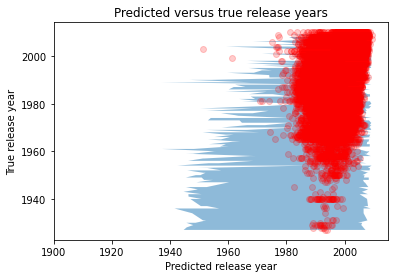

In [30]:
idx_sort = np.argsort(test_y)
plt.fill_betweenx(
    test_y[idx_sort],
    y_pi_low[idx_sort],
    y_pi_high[idx_sort],
    alpha=0.5
)
plt.scatter(y_pred[idx_sort], test_y[idx_sort], c="r", alpha=0.2)
plt.xlim(1900, 2015)
plt.title("Predicted versus true release years")
plt.xlabel("Predicted release year")
plt.ylabel("True release year")
plt.show()

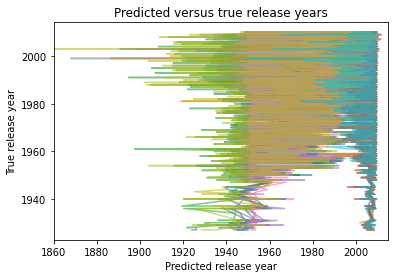

In [50]:
idx_sort = np.argsort(test_y)
for idx in range(y_pred_out.shape[1]):
    plt.plot(y_pred_pi_low[idx_sort, idx], test_y[idx_sort], alpha=0.6)
    plt.plot(y_pred_pi_high[idx_sort, idx], test_y[idx_sort], alpha=0.6)
plt.xlim(1860, 2015)
plt.title("Predicted versus true release years")
plt.xlabel("Predicted release year")
plt.ylabel("True release year")
plt.show()